# Statistical Properties of Limit Order Books

This notebook focuses on observing some fundamental empirical facts of Limit Order Book. Basic statistical properties of limit order books, which can be observed from real data (intraday) are studied.

The data is obtained from [TAQ data NYSE](https://www.nyse.com/market-data/historical/taq-integrated-feed) which contains data of all trade, depth of book, stock summary, order imbalance of all stocks traded on NYSE.

Information about AAPL stock on 03.03.2020 is used for the observation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
import math
import time
import datetime

## 1. Data Importing and Cleaning

In [3]:
df = pd.read_csv("aapl_ibf.csv", header=None)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,3,5187,AAPL,9,55,Q,C,100.0,298.81,0,0.0,N,.0001,1
1,34,5189,00:21:39.955956224,AAPL,1,P,~,NaN,NaN,NaN,NaN,NaN,~,P
2,34,5502,03:58:00.001130752,AAPL,2,D,~,NaN,NaN,NaN,NaN,NaN,~,P
3,34,8330,07:00:00.016579072,AAPL,3,E,~,NaN,NaN,NaN,NaN,NaN,~,E
4,100,8331,07:00:00.016579840,AAPL,4,15481162373791751,268.88,5.0,B,,0.0,NaN,NaN,NaN


Here the 0th column shows the MsgType of the event.

Extracting add order msgs (MsgType:100)

In [6]:
add_ord_df = df[df[0]==100]
add_ord_df.columns = ['msgType', 'seqNo', 'time', 'sym', 'symSeqNo', 'ordId', 'price', 'volume', 'side', 'nine', 'ten', 'eleven', 'twelve', 'thirteen']

In [7]:
add_ord_df.head()

,msgType,seqNo,time,sym,symSeqNo,ordId,price,volume,side,nine,ten,eleven,twelve,thirteen
4,100,8331,07:00:00.016579840,AAPL,4,15481162373791751,268.88,5.0,B,,0.0,NaN,NaN,NaN
5,100,9199,07:25:12.713550336,AAPL,5,15481162373795648,302,1000.0,S,,0.0,NaN,NaN,NaN
11,100,12849,08:01:26.327212800,AAPL,11,15481162373804873,300.8,875.0,B,,0.0,NaN,NaN,NaN
17,100,13648,08:06:46.675132672,AAPL,17,15481162373806079,300,35.0,S,,0.0,NaN,NaN,NaN
19,100,16448,08:25:56.033052416,AAPL,19,15481162373809085,302.83,100.0,S,,0.0,NaN,NaN,NaN


Removing columns 9 - 13.

In [8]:
add_ord_df.drop(['nine', 'ten', 'eleven', 'twelve', 'thirteen'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
add_ord_df.head()

,msgType,seqNo,time,sym,symSeqNo,ordId,price,volume,side
4,100,8331,07:00:00.016579840,AAPL,4,15481162373791751,268.88,5.0,B
5,100,9199,07:25:12.713550336,AAPL,5,15481162373795648,302,1000.0,S
11,100,12849,08:01:26.327212800,AAPL,11,15481162373804873,300.8,875.0,B
17,100,13648,08:06:46.675132672,AAPL,17,15481162373806079,300,35.0,S
19,100,16448,08:25:56.033052416,AAPL,19,15481162373809085,302.83,100.0,S


In [10]:
add_ord_df.dtypes

msgType       int64
seqNo         int64
time         object
sym          object
symSeqNo      int64
ordId        object
price        object
volume      float64
side         object
dtype: object

In [11]:
def strTons(string):
    ts = string.split('.')
    hms = ts[0].split(':')
    ns = ts[1]
    return pd.Timestamp(2020, 3, 3, int(hms[0]), int(hms[1]), int(hms[2]), int(ns[:3])).value // 1000000

In [12]:
add_ord_df['time'] = add_ord_df['time'].apply(func=strTons)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
add_ord_df.head()

,msgType,seqNo,time,sym,symSeqNo,ordId,price,volume,side
4,100,8331,1583218800000,AAPL,4,15481162373791751,268.88,5.0,B
5,100,9199,1583220312000,AAPL,5,15481162373795648,302,1000.0,S
11,100,12849,1583222486000,AAPL,11,15481162373804873,300.8,875.0,B
17,100,13648,1583222806000,AAPL,17,15481162373806079,300,35.0,S
19,100,16448,1583223956000,AAPL,19,15481162373809085,302.83,100.0,S


In [14]:
start_time = strTons('09:30:00.000000000')
end_time = strTons('16:00:00.000000000')
print(start_time, end_time)

1583227800000 1583251200000


In [15]:
add_ord_df = add_ord_df[add_ord_df['time'] > start_time]
add_ord_df = add_ord_df[add_ord_df['time'] < end_time]

In [16]:
add_ord_df.head()

,msgType,seqNo,time,sym,symSeqNo,ordId,price,volume,side
43,100,44286,1583227801000,AAPL,43,15481162373827364,303.52,100.0,S
46,100,45033,1583227802000,AAPL,46,15481162373828750,300.51,1.0,B
47,100,45506,1583227803000,AAPL,47,15481162373829758,303.81,100.0,S
48,100,45781,1583227803000,AAPL,48,15481162373830010,298.54,100.0,B
49,100,45882,1583227804000,AAPL,49,15481162373830145,301.2,200.0,B


Converting time from the format 'hh:mm:ss.nnnnnnnnn' to the number of milliseconds passed from the start of day.

## 2. Time of arrival of orders

In [17]:
end_time - start_time

23400000

Total number of milliseconds from the start time to end time of a trading day is 2,34,00,000 ms.

In [19]:
arr_t_b = pd.Series(add_ord_df[add_ord_df['side']=='B']['time'])
arr_t_s = pd.Series(add_ord_df[add_ord_df['side']=='S']['time'])

In [14]:
arr_t_b = arr_t_b[arr_t_b > start_time]
arr_t_b = arr_t_b[arr_t_b < end_time]

arr_t_s = arr_t_s[arr_t_s > start_time]
arr_t_s = arr_t_s[arr_t_s < end_time]

In [20]:
arr_t_b = arr_t_b - start_time
arr_t_s = arr_t_s - start_time

In [21]:
arr_t_b.index = list(range(1, len(arr_t_b)+1))
arr_t_s.index = list(range(1, len(arr_t_s)+1))

In [22]:
arr_t_b_count = dict()
for i in arr_t_b:
    if i in arr_t_b_count:
        arr_t_b_count[i] += 1
    else:
        arr_t_b_count[i] = 1

In [23]:
atbc = sorted(arr_t_b_count.items())
x,y = zip(*atbc)

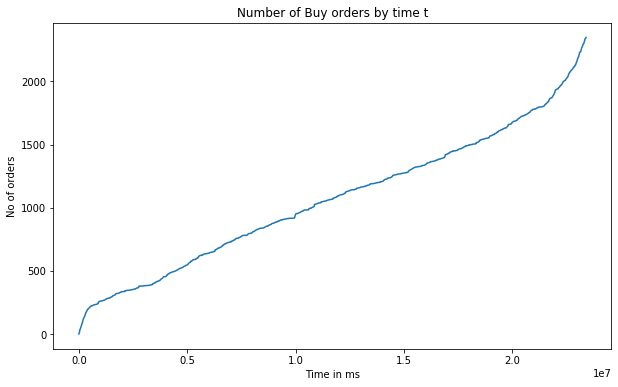

In [60]:
fig = plt.figure(figsize=(10,6))
plt.plot(x, np.cumsum(y))
plt.title("Number of Buy orders by time t")
plt.ylabel("No of orders")
plt.xlabel("Time in ms")
plt.show()

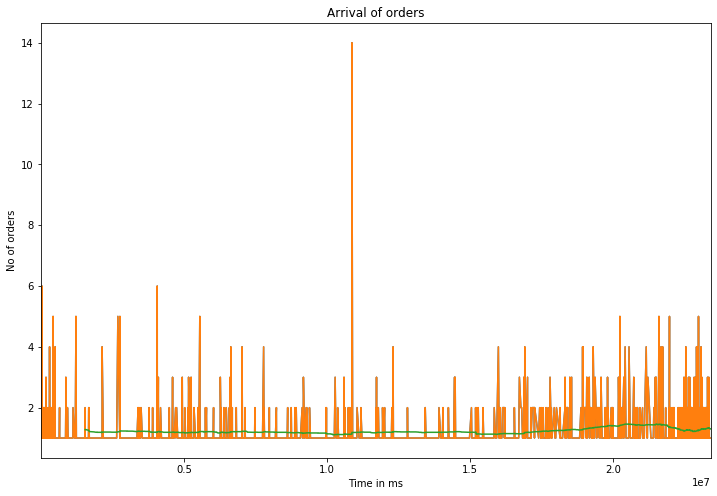

In [24]:
fig = plt.figure(figsize=(12,8))
plt.plot(x, y)
pd.Series(y, index=x).plot()
pd.Series(y, index=x).rolling(window=234).mean().plot()
plt.title("Arrival of orders")
plt.ylabel("No of orders")
plt.xlabel("Time in ms")
plt.show()

The graph describes the number of orders arrived on every milliseconds throughout the day.

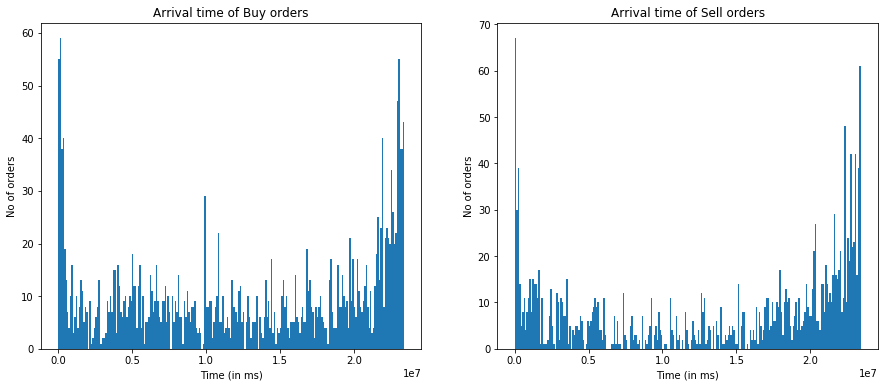

In [25]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#arr_t_b.plot()
#arr_t_b.rolling(window=3).mean().plot()
#ax1 = arr_t_b.plot()
ax1.hist(arr_t_b, bins=234)
ax1.set_xlabel("Time (in ms)")
ax1.set_title("Arrival time of Buy orders")
ax1.set_ylabel("No of orders")

#arr_t_s.plot()
#arr_t_s.rolling(window=3).mean().plot()
ax2.hist(arr_t_s, bins=234)
ax2.set_title("Arrival time of Sell orders")
ax2.set_xlabel("Time (in ms)")
ax2.set_ylabel("No of orders")
plt.show()

It can be observed that it follows a U-shaped pattern which denotes, most stocks were traded at beginning and end of the day.

Calculating the Inter arrival time of the add new orders.

In [36]:
iat_b = (np.hstack((arr_t_b.iloc[1:], [0])) - np.array(arr_t_b))[:-1]
iat_s = (np.hstack((arr_t_s.iloc[1:], [0])) - np.array(arr_t_s))[:-1]

In [37]:
iat_b_count = dict()
for i in iat_b:
    if i in iat_b_count:
        iat_b_count[i] += 1
    else:
        iat_b_count[i] = 1

In [38]:
iat_s_count = dict()
for i in iat_s:
    if i in iat_s_count:
        iat_s_count[i] += 1
    else:
        iat_s_count[i] = 1

In [39]:
db = dict(sorted(iat_b_count.items()))
db_keys = np.array(list(db.keys()))
db_vals = np.array(list(db.values()))
mu_b = db_keys.mean()
std_b = db_keys.std()

In [40]:
ds = dict(sorted(iat_s_count.items()))
ds_keys = np.array(list(ds.keys()))
ds_vals = np.array(list(ds.values()))
mu_s = ds_keys.mean()
std_s = ds_keys.std()

In [41]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

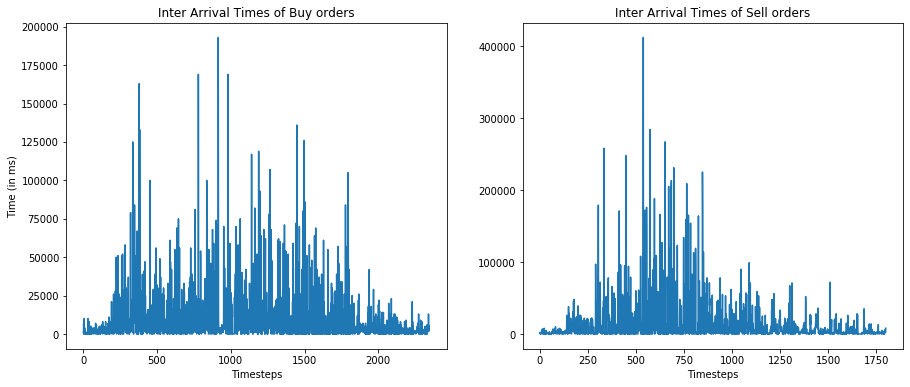

In [42]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(list(range(len(iat_b))), iat_b)
ax1.set_xlabel("Timesteps")
ax1.set_ylabel("Time (in ms)")
ax1.set_title("Inter Arrival Times of Buy orders")
ax2.plot(list(range(len(iat_s))), iat_s)
ax2.set_xlabel("Timesteps")
ax2.set_title("Inter Arrival Times of Sell orders")
plt.show()

Fitting Empirical Distributions to the inter arrival times.

In [43]:
e_b = ECDF(iat_b)
e_s = ECDF(iat_s)

In [46]:
# Exponential Distribution
lam_b = 1/mu_b
ex_bpdf = []
ex_bcdf = []
for i in db_keys:
    ex_bpdf.append(lam_b*np.exp(-lam_b*i))
    ex_bcdf.append(1-np.exp(-lam_b*i))

lam_s = 1/mu_s
ex_spdf = []
ex_scdf = []
for i in ds_keys:
    ex_spdf.append(lam_s*np.exp(-lam_s*i))
    ex_scdf.append(1-np.exp(-lam_s*i))

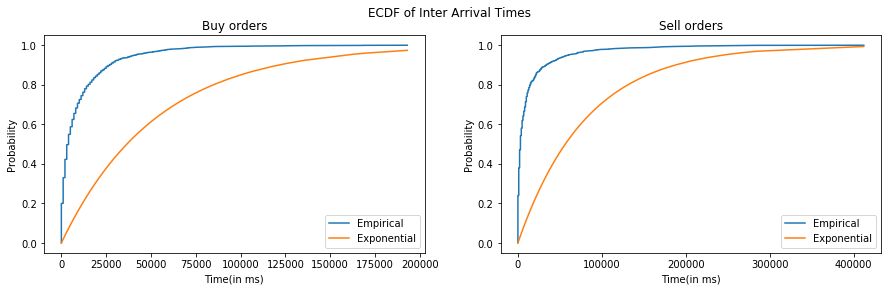

In [48]:
fig = plt.figure(figsize=(15, 4))
fig.suptitle("ECDF of Inter Arrival Times")
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(e_b.x, e_b.y, label='Empirical')
ax1.plot(db_keys, ex_bcdf, label='Exponential')
ax1.set_title("Buy orders")
ax1.set_xlabel("Time(in ms)")
ax1.set_ylabel("Probability")
ax1.legend()

ax2.plot(e_s.x, e_s.y, label='Empirical')
ax2.plot(ds_keys, ex_scdf, label='Exponential')
ax2.set_title("Sell orders")
ax2.set_xlabel("Time(in ms)")
ax2.set_ylabel("Probability")
ax2.legend()
plt.show()

## 3. Volume of orders

In [49]:
vol_b = pd.Series(add_ord_df[add_ord_df['side']=='B']['volume'])
vol_s = pd.Series(add_ord_df[add_ord_df['side']=='S']['volume'])
vol_b.index = list(range(1, len(arr_t_b)+1))
vol_s.index = list(range(1, len(arr_t_s)+1))

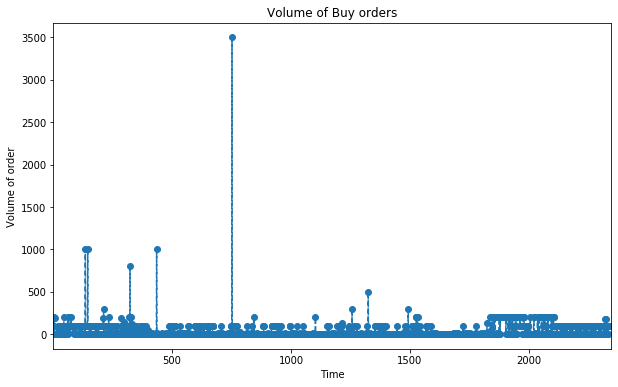

In [50]:
fig = plt.figure(figsize=(10,6))
vol_b.plot(marker='o', linestyle='--')
plt.title("Volume of Buy orders")
plt.xlabel("Time")
plt.ylabel("Volume of order")
plt.show()

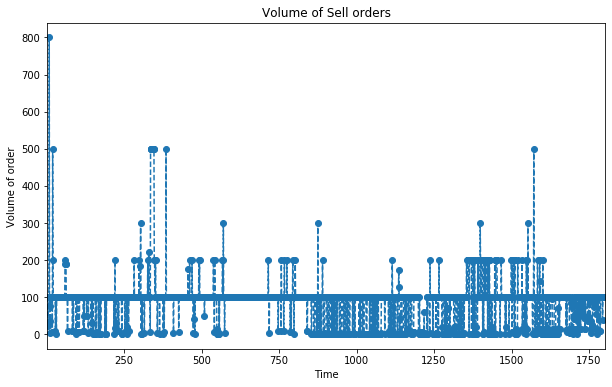

In [51]:
fig = plt.figure(figsize=(10,6))
vol_s.plot(marker='o', linestyle='--')
plt.title("Volume of Sell orders")
plt.xlabel("Time")
plt.ylabel("Volume of order")
plt.show()

## 4. Price Dynamics

In [52]:
pr_b = pd.Series(add_ord_df[add_ord_df['side']=='B']['price']).astype(float)
pr_s = pd.Series(add_ord_df[add_ord_df['side']=='S']['price']).astype(float)
pr_b.index = arr_t_b
pr_s.index = arr_t_s

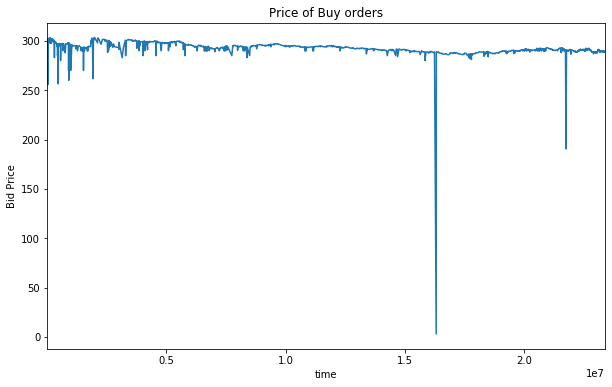

In [53]:
fig = plt.figure(figsize=(10,6))
pr_b.plot()
plt.title("Price of Buy orders")
plt.ylabel("Bid Price")
plt.show()

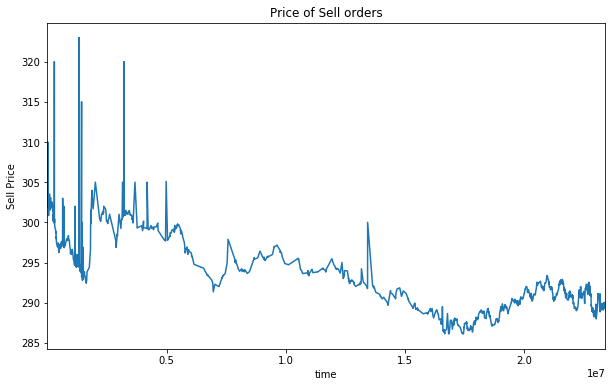

In [54]:
fig = plt.figure(figsize=(10,6))
pr_s.plot()
plt.title("Price of Sell orders")
plt.ylabel("Sell Price")
plt.show()